<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/58/Uber_logo_2018.svg/1024px-Uber_logo_2018.svg.png" alt="UBER LOGO" width="50%" />

# UBER Pickups 

La problématique rencontrée par l'équipe d'Uber découle du constat suivant : les chauffeurs ne sont pas présents dans les zones ou les utilisateurs ont un besoin.

## Goals 🎯

Uber dispose déjà de données sur les collectes dans les grandes villes. Notre objectif est de créer des algorithmes qui détermineront où se trouvent les zones chaudes dans lesquelles les conducteurs doivent se trouver.Nous allons donc:

* Créer un algorithme pour trouver des zones chaudes 
* Visualisez les résultats sur un joli tableau de bord 

In [2]:
!pip install plotly -q

In [3]:
# import librairies
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "iframe_connected"
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import  silhouette_score
import matplotlib.pyplot as plt

In [4]:
# On merge tous les dataset en un seul
data_aprl= pd.read_csv("uber-raw-data-apr14.csv")
data_aug= pd.read_csv("uber-raw-data-aug14.csv")
data_jun= pd.read_csv("uber-raw-data-jun14.csv")
data_jul= pd.read_csv("uber-raw-data-jul14.csv")
data_may= pd.read_csv("uber-raw-data-may14.csv")
data_sep= pd.read_csv("uber-raw-data-sep14.csv")
data= pd.concat([data_aprl, data_aug ,data_jun ,data_jul, data_may, data_sep], ignore_index=True )

In [5]:
data.head()

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


Chaque ligne dans ce dataset correspond à une commande d'un client 

In [6]:
data.shape

(4534327, 4)

**Convert Datetime to Year, Month, Day and Day of week**

In [7]:
# Create a second column conerning the date and the hour for all the months

data['Week'] =pd.to_datetime(data['Date/Time']).dt.isocalendar().week
data['Year'] = pd.to_datetime(data['Date/Time']).dt.isocalendar().year
data['Month'] = pd.to_datetime(data['Date/Time']).dt.month
data['Week_day'] = pd.to_datetime(data['Date/Time']).dt.weekday
# The new Date column can be used thanks to the datetime format compare to 
# previous one
data['Date/Time'] = pd.to_datetime(data['Date/Time'])
data['Date/Time'].sort_values()
data[["Hours","Minutes"]] = pd.DataFrame([(x.hour, x.minute) for x in data["Date/Time"]])

In [8]:
data['weekday_name'] = data['Date/Time'].dt.day_name()
data.head()

,Date/Time,Lat,Lon,Base,Week,Year,Month,Week_day,Hours,Minutes,weekday_name
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,14,2014,4,1,0,11,Tuesday
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,14,2014,4,1,0,17,Tuesday
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,14,2014,4,1,0,21,Tuesday
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,14,2014,4,1,0,28,Tuesday
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,14,2014,4,1,0,33,Tuesday


In [9]:
for columns in data:
    print(columns," missing value", data[columns].isna().sum() )

Date/Time  missing value 0
Lat  missing value 0
Lon  missing value 0
Base  missing value 0
Week  missing value 0
Year  missing value 0
Month  missing value 0
Week_day  missing value 0
Hours  missing value 0
Minutes  missing value 0
weekday_name  missing value 0


- No missing values in data

In [10]:
data.Week_day.value_counts()

3    755145
4    741139
2    696488
1    663789
5    646114
0    541472
6    490180
Name: Week_day, dtype: int64

In [11]:
data.weekday_name.value_counts()

Thursday     755145
Friday       741139
Wednesday    696488
Tuesday      663789
Saturday     646114
Monday       541472
Sunday       490180
Name: weekday_name, dtype: int64

Nous voulons regarder la répartition des demandes Uber selon le jour de la semaine et l'heure de la journée, afin d'identifier les horraires les plus cruciaux :

**Analyse des trajets par jours de la semaine**

Text(0.5, 1.0, 'Day repartition of Uber requests for all Weeks')

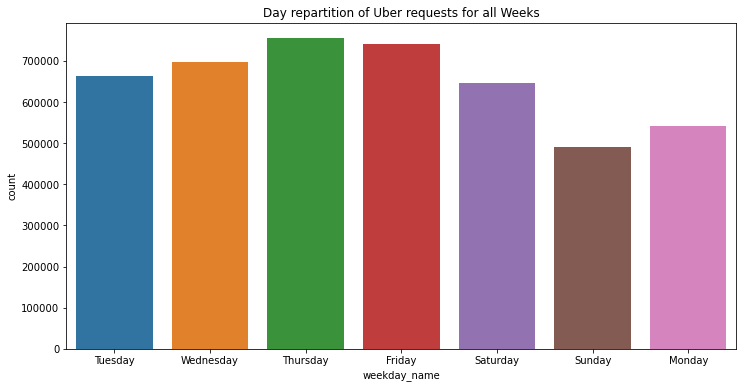

In [12]:
plt.figure(figsize=(12,6))
sns.countplot(x="weekday_name",data=data)
plt.title('Day repartition of Uber requests for all Weeks')

**Observation**
- Une forte demande le jeudi et vendredi 
- Moins de demandes le dimanche et lundi, presque la même répartition des demandes pour le reste des jours 

In [13]:
data.Hours.value_counts()

17    336190
18    324679
16    313400
19    294513
20    284604
21    281460
15    275466
22    241858
14    230625
13    195877
7     193094
8     190504
12    170452
23    169190
11    165703
9     159967
10    159148
6     143213
0     103836
5      83939
1      67227
4      55230
3      48287
2      45865
Name: Hours, dtype: int64

**Analyse des trajets par heures**

Text(0.5, 1.0, 'Hour repartition of Uber requests for all Days')

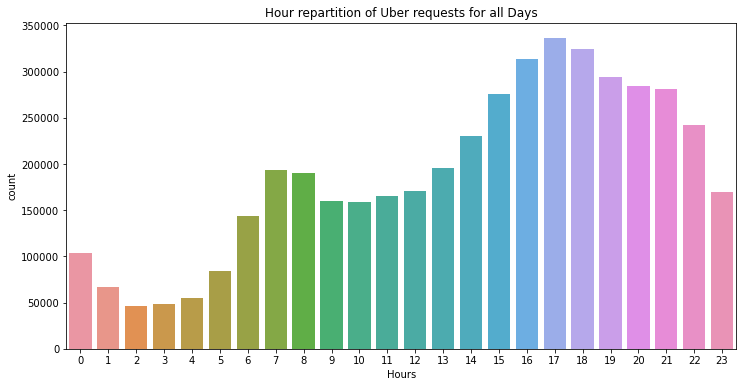

In [14]:
plt.figure(figsize=(12,6))
sns.countplot(x="Hours",data=data)
plt.title('Hour repartition of Uber requests for all Days')

**Observation**
- Moins de demande avant 6h
- Une augmentation des demandes à partir de 6h du matin, puis stagnant de 9h à 12h 
- une nouvelle augmentation jusqu'au 18, puis une baisse global jusqu'à la fin de la journée

***Analyse approfondie des heures/jours de pointe à New York***

Nous allons observer les données pour chaque heure/jour de la semaine afin de voir les tendances pour chaque heure de la journée durant les jours de la semaine. 

In [15]:
data_heures_jours_pointe= data.groupby(["weekday_name","Hours"])["Date/Time"].count().reset_index()
data_heures_jours_pointe.columns=['Day of week','Hour','Trips']
data_heures_jours_pointe.head()

,Day of week,Hour,Trips
0,Friday,0,13716
1,Friday,1,8163
2,Friday,2,5350
3,Friday,3,6930
4,Friday,4,8806


<AxesSubplot:xlabel='Hour', ylabel='Trips'>

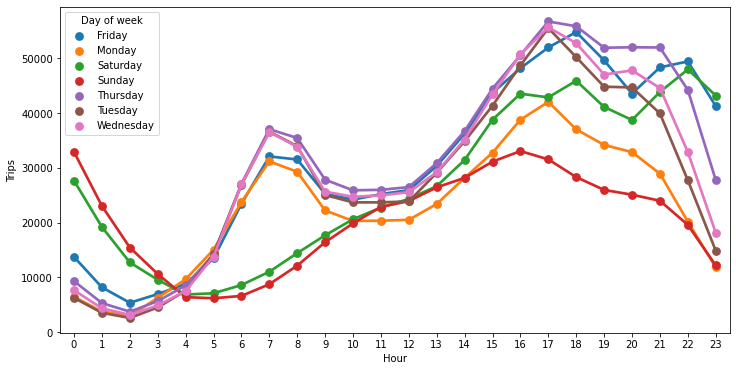

In [16]:
plt.figure(figsize=(12,6))
sns.pointplot(x='Hour',y='Trips',hue='Day of week',data=data_heures_jours_pointe)

**Observation**
- De 0h à 3h du matin : la plupart des jours ont peu de demande dans cette plage horaire, sauf les samedis et dimanches qui ont ici une demande importante (due évidemment aux personnes qui sortent plus tard le week-end)
- De 3h à 5h du matin : pas grand chose à dire, la demande est faible pour tous les jours de la semaine
- De 6h à 8h : les demandes sont importantes les jours ouvrés mais beaucoup plus faibles les samedis et dimanches
- De 9h à 16h : la répartition est la même pour tous les jours de la semaine
- De 17h à 20h : tous les jours sont quasiment égaux, sauf le dimanche qui est inférieur 
- Fin de journée (22h, 23h) : principalement les vendredis et samedis. Le jeudi est également présent à 22

# KMeans 
*Definition:*
> - Separate sample in n groups of equal variance
> - Distance between data points and center
> - top-down algorithm, starts from sets ends to observations

- Nos données sont réparties dans la zone géographique de New York, il y a donc une distance euclidienne.
- Nous sommes donc capables d'utiliser la méthode K-Means qui est une technique qui sépare les observations par clusters où chaque observation est considérée comme appartenant à un groupe où la moyenne est la plus proche selon une distance donnée.
- Pour savoir le nombre de clusters nous allons utiliser la méthode Elbow, et de la silhouette.



**Preprocessing of the data**

In [17]:
# Nous travaillerons uniquement sur 25000 lignes 
#car les calculs seraient beaucoup trop longs sur plus de 4M lignes 
# Nous gardons seulement les colonnes utiles 
data_sample=data[["Lat", "Lon", "Week_day","Hours"]].sample(25000)
data_sample.head()

,Lat,Lon,Week_day,Hours
2663223,40.7297,-74.0022,3,10
1657035,40.7295,-74.0022,6,0
2963917,40.7402,-73.9919,4,18
2591216,40.7430,-73.9931,6,3
2507430,40.7223,-73.9577,5,22


In [18]:
sc = StandardScaler()
X = sc.fit_transform(data_sample[["Lat", "Lon"]]) #pour normaliser les variables

In [19]:
print(X[0:5, :])

[[-0.24428172 -0.51678883]
 [-0.24932193 -0.51678883]
 [ 0.02032895 -0.33571139]
 [ 0.0908918  -0.35680779]
 [-0.43076925  0.26553604]]


***1.Elbow method***
  >- Vérifier si les points de données d'un cluster sont proches de leur centroïde
  >- Plus nous obtenons de clusters, moins l'inertie (wcss) sera différente
  >- Indique le degré d'homogénéité des valeurs au sein d'un cluster

We are going to build our clusters, but to do so, we need to know the optimum number of clusters we need. First use the **Elbow** method to see if we can see how many we need to take as a value for **k**.

In [ ]:
# Utilisation de la méthode Elbow pour trouver le nombre optimal de clusters
wcss =  []
for i in range (2,11): 
    kmeans = KMeans(n_clusters= i)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    
print(wcss)

[35102.594635152185, 24142.247951877587, 19603.10612186493, 16475.224975128534, 13157.554244921346, 10827.015039597529, 9449.553714064876, 8156.61315782165, 7220.0033715053705]


In [ ]:
fig = px.line(x = range(2,11), y = wcss)
fig.show()

**2.Silhouette method**
> - Vérifiez si les clusters sont éloignés les uns des autres
> - Nous indique à quel point nos clusters sont distincts les uns des autres

Then use the **Silhouette** method to see if we can refine our hypothesis for **k**

In [22]:
# Utilisation du silhouette_score pour déterminer le nombre optimal de clusters
# Il faut commencer à i=2 car le score silhouette 
#ne peut accepter moins de 2 labels
s_score = []
for i in range (2,11): 
    kmeans = KMeans(n_clusters= i)
    kmeans.fit(X)
    s_score.append(silhouette_score(X, kmeans.predict(X)))

print(s_score)

[0.7046703066838058, 0.4074990903097684, 0.42610883422033313, 0.4426687016153903, 0.4489358214502594, 0.4651108319008308, 0.4675447874835925, 0.4270943738724437, 0.388196380049986]


In [23]:
# Affichage de scores en fonction du nombre de clusters
fig = px.bar(x = range(2,11), y = s_score)
fig.show()

In [24]:
# On ré-entraîne un KMeans avec le nombre optimal de clusters
kmeans = KMeans(n_clusters= 8)
kmeans.fit(X)

KMeans()

In [25]:
Cluster_KMeans= kmeans.predict(X)

In [26]:
data_sample["Cluster_KMeans"]=Cluster_KMeans.copy()

In [27]:
data_sample.head()

,Lat,Lon,Week_day,Hours,Cluster_KMeans
2663223,40.7297,-74.0022,3,10,6
1657035,40.7295,-74.0022,6,0,6
2963917,40.7402,-73.9919,4,18,6
2591216,40.7430,-73.9931,6,3,6
2507430,40.7223,-73.9577,5,22,6


In [28]:
data_sample.Cluster_KMeans.value_counts()

6    10344
1     9503
0     2396
3      945
2      766
4      716
5      260
7       70
Name: Cluster_KMeans, dtype: int64

Bien que les deux méthodes essaient de déterminer dans quelle mesure nos données sont bien divisées, elles proposent deux approches opposées.

La méthode Elbow essaie de voir si chaque point de données d'un cluster sont proches les uns des autres . La Silhouette essaie de déterminer à quelle distance se trouve chaque groupe (et donc à quel point ils sont significatifs).


- Grâce à c'est deux méthodes nous sommes maintenant en mesure de définir le nombre de clusters qui est de 8.

In [29]:
# Mask réalisé pour une map sur un créneau horaire défini :  à 17h 
fig=px.scatter_mapbox(data_sample[data_sample["Hours"]==17], lat="Lat", lon="Lon", color="Cluster_KMeans",mapbox_style="carto-positron")
fig.show()

In [30]:
# Mask réalisé pour une map sur un créneau horaire défini : sur tout le vendredi  
 

fig = px.scatter_mapbox(data_sample[data_sample["Week_day"]==4].sort_values(by=['Week_day', 'Hours']),
                        lat='Lat',
                        lon='Lon',
                        color="Cluster_KMeans",
                        animation_frame = 'Hours',
                        zoom=9,
                        mapbox_style = 'carto-positron')

fig.show(renderer='iframe')

In [31]:
# map sur un créneau horaire défini : sur tous les jours de la semaine
fig = px.scatter_mapbox(data_sample.sort_values(by=['Week_day']),
                        lat='Lat',
                        lon='Lon',
                        color="Cluster_KMeans",
                        animation_frame = 'Week_day',
                        zoom=9,
                        mapbox_style = 'carto-positron')

fig.show(renderer='iframe')


- Maintenant nous pouvons visualiser les données de notre modèle K-means on peut voir qu'il a divisé un ensemble de données en différents « paquets » homogènes en fonction de K.
- 8 clusters ont été définis avec un nombre de point très dense dans le nord et le sud de MANHATTAN ( cluster 1;3;6; ) à n'importe quel jour/heure de la semaine entraînant une demande constante de chauffeur

- On constate cependant que certains clusters ne nécessitent pas une présence accrue des chauffeurs car la demande semble moins importante (clusters 0;2;5;4;7).
 
- Il est donc préférable de planifier une grosse flottes de véhicules sur les points stratégiques, clusters (0;1;3;4;8 )comme le centre de New York ou la demande est constante mais également sur les aéroports en fonction des pîques d'affluence.


- KMeans est utile pour faire une séparation mais il ne renseigne pas sûr, c'est pour ça on va essayer de péciser plus en utilsant la methode DBSCAN.


# DBSCAN
> - Créer un cluster en fonction de la proximité de chaque échantillon les uns des autres
> - Densité des points de données dans l'espace

- L’algorithme DBSCAN utilise 2 paramètres : la distance epsilon (une distance physique de chaque point) et le nombre minimum de points “min_sample” (taille de cluster minimale) devant se trouver dans un rayon epsilon pour que ces points soient considérés comme un cluster.
- Cette méthode est parfaite pour les données spatiales latitude-longitude.


In [33]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.15, min_samples=100, metric="manhattan")

db.fit(X)

DBSCAN(eps=0.15, metric='manhattan', min_samples=100)

In [34]:
np.unique(db.labels_)

array([-1,  0,  1,  2,  3,  4,  5])

In [35]:
data_sample["cluster"] = db.labels_
data_sample.head()

,Lat,Lon,Week_day,Hours,Cluster_KMeans,cluster
2663223,40.7297,-74.0022,3,10,6,0
1657035,40.7295,-74.0022,6,0,6,0
2963917,40.7402,-73.9919,4,18,6,0
2591216,40.7430,-73.9931,6,3,6,0
2507430,40.7223,-73.9577,5,22,6,1


In [36]:
# Mask réalisé pour une map sur un créneau horaire défini :  à 17h 

fig = px.scatter_mapbox(
       data_sample[data_sample["Hours"]==17].loc[data_sample.cluster != -1, :], 
        lat="Lat", 
        lon="Lon",
        color="cluster",
        mapbox_style="carto-positron"
)

fig.show()

In [37]:
# Mask réalisé pour une map sur un créneau horaire défini : sur toutes les heures de vendredi
fig = px.scatter_mapbox(
        data_sample[data_sample["Week_day"]==4].sort_values(by=['Week_day', 'Hours'])[data_sample.cluster!= -1], 
        lat="Lat", 
        lon="Lon",
        color="cluster",
        animation_frame = 'Hours',
        zoom=9,
        mapbox_style="carto-positron"
)

fig.show(renderer='iframe')

/tmp/ipykernel_50/2688037613.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [38]:
# map sur un créneau horaire défini : sur tous les jours de la semaine
fig = px.scatter_mapbox(data_sample.sort_values(by=['Week_day', 'Hours'])[data_sample.cluster!= -1],
                        lat='Lat',
                        lon='Lon',
                        color='cluster',
                        animation_frame = 'Week_day',
                        zoom=9,
                        mapbox_style = 'carto-positron')

fig.show(renderer='iframe')

/tmp/ipykernel_50/1518944512.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [39]:
# map sur un créneau horaire défini : sur toutes heures  jours de la semaine
fig = px.scatter_mapbox(data_sample.sort_values(by=['Week_day', 'Hours'])[data_sample.cluster!= -1],
                        lat='Lat',
                        lon='Lon',
                        color='cluster',
                        animation_frame = 'Hours',
                        zoom=9,
                        mapbox_style = 'carto-positron')

fig.show(renderer='iframe')

/tmp/ipykernel_79/3961952269.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



- Pour DBSCAN, nous ne pouvons pas définir le nombre de clusters attendu en paramètre car l'algorithme essaie de trouver lui-même le nombre de clusters.

- DBSCAN crée des clusters de plus forte densitée et catégorise les points non clusterisé comme du bruit qui sont représentés comme des outliers.


# Conclusion
- DBSCAN a mis en évidence nos données de façon concentrées et nous a permis de déterminer l'emplacement exact ou devrait se placer les chauffeurs Uber afin de répondre au mieux aux attentes des clients et limiter au maximum le temps d'attente comme les aéroports, Le Grand Army Plaza , Meatpacking District, le Theater District, Midtown et Midtown EST.
- Pour finir, le model DBSCAN permettra à Uber de placer ses véhicules de façon stratégique en complémentarité avec le model K-means, qui lui indiquera les zones chaudes à couvrir par les chauffeurs pour satisfaire au maximum la demande.